Overview:

1. Single Cell Model
2. Network Simulations
3. Fit of the Transfer Function
4. Mean Field Model
5. Whole Brain Model
6. PCI
7. BOLD and FC
8. Dynamical Analysis

Single Cell Model

AdEx: 

$c_{m}  \frac{dv}{dt}  =  g_L(E_L-v)+ g_L\Delta e^{\frac{v-v_{thr}}{\Delta }} -W + I_{syn}$  

$\frac{dW}{dt}  =  -\frac{1}{\tau_w} (a(v-E_L) - W) + b \sum_{t_{sp}}\delta(t-t_{sp})$

In [30]:
import matplotlib.pyplot as plt
from brian2 import *
import ptitprince as pt
import seaborn as sns
import matplotlib.colors as mplcol


In [95]:
%precision 2
%load_ext autoreload
%autoreload 2

from functions import *
from codes_analyses import *
import tvb_model_reference.src.nuu_tools_simulation_human as tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
from tvb_model_reference.simulation_file.parameter.parameter_M_Berlin_new import Parameter
parameters = Parameter()



In [2]:
%matplotlib inline


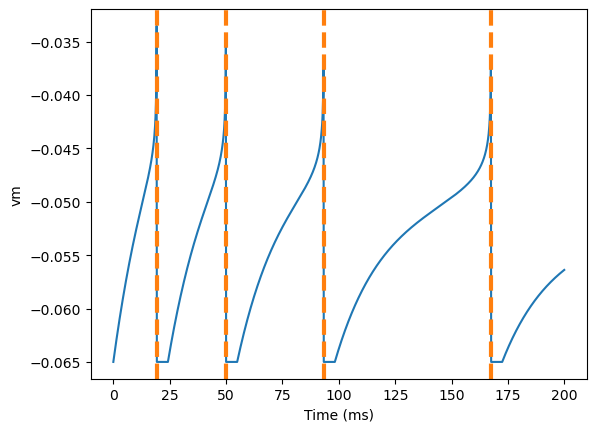

In [13]:
start_scope()
tau = 10*ms
C = 200*pF
gL = 10*nS
tauw = 500*ms
a =.0*nS# 4*nS
Ee=0*mV
Ei=-80*mV
I = .3*nA

b_e = 60
tau_e = 5.0
tau_i = 5.0

EL_i = -65.0
EL_e = -64.0

eqs = """
dvm/dt=(gL*(EL-vm)+gL*DeltaT*exp((vm-VT)/DeltaT)-GsynE*(vm-Ee)-GsynI*(vm-Ei)+I-w)/C : volt (unless refractory)
dw/dt=(a*(vm-EL)-w)/tauw : amp
dGsynI/dt = -GsynI/TsynI : siemens
dGsynE/dt = -GsynE/TsynE : siemens
TsynI:second
TsynE:second
Vr:volt
b:amp
DeltaT:volt
Vcut:volt
VT:volt
EL:volt
"""

G_exc = NeuronGroup(1, model=eqs, threshold='vm > Vcut',refractory=5*ms,
                     reset="vm = Vr; w += b", method='heun')
G_exc.vm = -65*mV#EL
G_exc.w = a * (G_exc.vm - G_exc.EL)
G_exc.Vr = -65*mV 
G_exc.b=b_e*pA
G_exc.DeltaT=2*mV
G_exc.VT=-50.*mV
# G_exc.Vcut=G_exc.VT + 5 * G_exc.DeltaT
G_exc.Vcut = -30*mV
G_exc.EL=EL_e*mV
G_exc.TsynI =5*ms
G_exc.TsynE =5*ms

statemon = StateMonitor(G_exc, 'vm', record=0)
spikemon = SpikeMonitor(G_exc)

run(200*ms)

plot(statemon.t/ms, statemon.vm[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
xlabel('Time (ms)')
ylabel('vm');

Network Simulations

--##Start simulation##--
--##End simulation##--


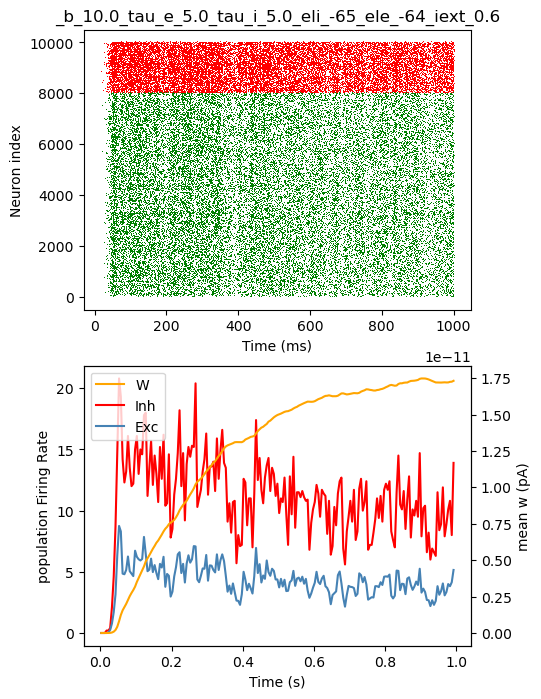

 done


In [10]:
%run adex_simulation_network.py --b_e=10.0 --iext=0.6

FIT

MEAN FIELD

starting
done


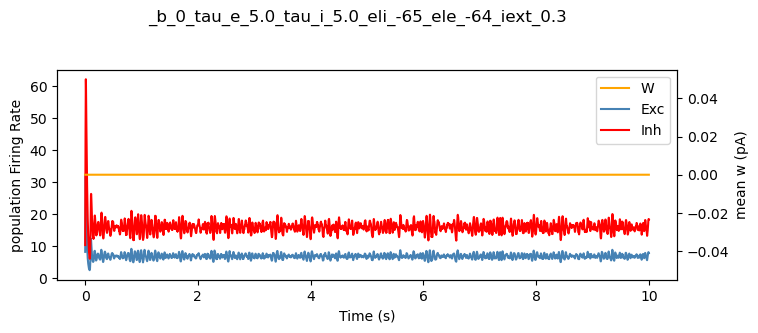

In [7]:
%run MF_script_with_OS.py

starting
done


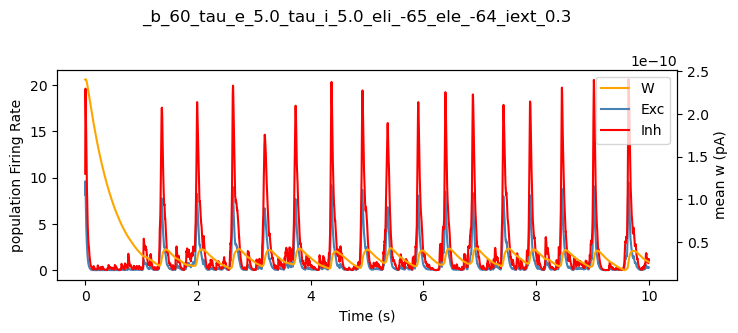

In [11]:
%run MF_script_with_OS.py --b_e=60

### Whole Brain Model ###

#### Set up the parameters of the simulation

In [5]:
## Set the parameters of the simulation:
run_sim = 600.0 # ms, length of the simulation
cut_transient = 200.0 # ms, length of the discarded initial segment

# List of values of adaptation strength and tau_e which will vary the brain state
bvals = [5]
tau_es = [3.75]
Iexts = [0.000315] # External input

## Set the parameters of the stimulus (choose stimval = 0 to simulate spontaneous activity)
stimval = 0 #  stimulus strength

#### Choose a connectome 

You have various options:

1. Get a default connectivity from TVB software
    
    a. parameters.parameter_connection_between_region['default'] = True

2. Point to a zip folder (required files included in the zip folder: centres, tract_lengths, weights)
    
    a. parameters.parameter_connection_between_region['from_file'] = True
    b. parameters.parameter_connection_between_region['path'] = path/to/zip/file
    c. parameters.parameter_connection_between_region['conn_name'] = 'Connectivity.zip' (add the actual zip name)

3. Point to an h5 file
    
    a. parameters.parameter_connection_between_region['path'] = path/to/h5/file CHECK

4. Point to an unzipped folder that contains necessarily tract_lengths.txt and weights.txt (optional: region_labels, centres,cortical)
    
    a. parameters.parameter_connection_between_region['path'] = path/to/folder/containing/files


In [159]:
# Choose the connectome

path_windows = r"C:\Users\maria\Downloads\tvb_data\tvb_data\connectivity"
path_linux = "/home/maria/Downloads/tvb_data/connectivity"
parameters.parameter_connection_between_region['from_file'] = True
parameters.parameter_connection_between_region['path'] = path_linux
parameters.parameter_connection_between_region['conn_name'] = 'connectivity_76.zip'

In [16]:
from tvb_model_reference.simulation_file.parameter.parameter_M_Berlin_new import Parameter
parameters = Parameter()

In [160]:
simulator = sim_init(parameters)
Nnodes = simulator.number_of_nodes

2024-04-03 17:02:50,514 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


In [45]:
Nnodes

76

#### Run the simulation

Here is an example of changinf tau_e and b_e

You can instead change tau_i, or other values (look at docs of adjust_parameters), by setting adding as argument tau_i = desired_value in the funcitons:
    adjust_parameters
    get_result

and set change_of = 'tau_i' in:
    access_results
    plot_tvb_results

In [88]:
# Choose values of b_e and tau_e
bvals = [60, 5]
tau_es = [5, 3.75]

In [89]:
# Run Simulation
for b_e, tau_e in zip(bvals, tau_es):
    parameters = adjust_parameters(parameters, b_e = b_e, tau_e = tau_e , n_nodes=Nnodes,cut_transient=cut_transient, run_sim=run_sim)

    simulator = sim_init(parameters)
    
    if stimval:
        print ('    Stimulating for {1} ms, {2} nS in the {0}\n'.format(simulator.connectivity.region_labels[stim_region],parameters.parameter_stimulus['tau'],stimval))

    tools.run_simulation(simulator, run_sim, parameters.parameter_simulation, parameters.parameter_monitor)

_b_e_60_tau_e_5_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_10
2024-04-02 17:40:19,052 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\maria\anaconda3\Lib\logging\handlers.py", line 74, in emit
    self.doRollover()
  File "c:\Users\maria\anaconda3\Lib\logging\handlers.py", line 435, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\Users\maria\anaconda3\Lib\logging\handlers.py", line 115, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\maria\\.tvb-temp\\logs\\library.log' -> 'C:\\Users\\maria\\.tvb-temp\\logs\\library.log.2023-12-18'
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\maria\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\maria\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "c:\Users\ma

simulation time :1000.0
simulation time :2000.0


In [154]:
# Params to load 
bvals = [60, 5]
tau_es = [5, 3.75]

result= []
for i, (b_e, tau_e) in enumerate(zip(bvals, tau_es)):
    result_param, for_explan = get_result(parameters,cut_transient, run_sim, b_e = b_e, tau_e = tau_e, vars_int = ['E', 'I' ,'W_e'])
    result.append(result_param)

# # For explanation of the indexes of the result, uncomment the following:
#     if i==len(bvals)-1:
#         access_results(for_explan, bvals, tau_es, change_of='tau_e')


Loading:  _b_e_60_tau_e_5_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_10
Loading:  _b_e_5_tau_e_3.75_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_10


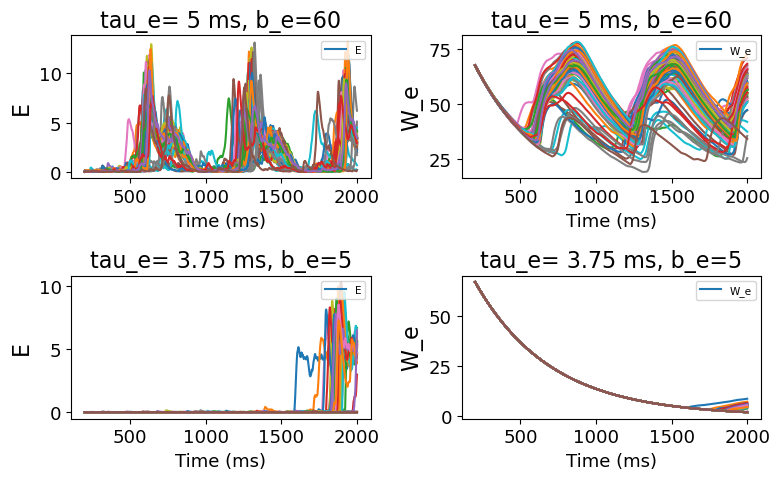

In [153]:
#Plot the results from TVB Simulations

#which monitor 
monitor = 'Raw'

#which variables
var_select = ['E',  'W_e']

#which params (b_e, tau) - to be in the same order as the loading results (see explanations)
params = [[60, 5], [5, 3.75]]
plot_tvb_results(parameters,params, result, monitor, for_explan, var_select,cut_transient, run_sim, change_of='tau_e', 
               Iext = 0.000315,nseed=10)

## Evoked Dynamics #

#### Set up the parameters of the simulation

In [47]:
## Set the parameters of the simulation:
run_sim = 4000.0 # ms, length of the simulation
cut_transient = 2000.0 # ms, length of the discarded initial segment

# List of values of adaptation strength and tau_e which will vary the brain state
bvals = [5]
tau_es = [3.75]
Iexts = [0.000315] # External input

## Set the parameters of the stimulus (choose stimval = 0 to simulate spontaneous activity)
stimval = 1e-3 #  stimulus strength in kHz - HERE NO ZERO ANYMORE
t_analysis  = 300. #in ms, for PCI analysis

# Loop over seeds to obtain multi5ple realizations of the model
Nseeds = 2 #Number of seeds has been reduced from 50 in the manuscript to 5 in the demonstrator for the reviewers' convenience 


# Onset time of the stimulus
stimtime_allseeds = np.random.rand(Nseeds)*(run_sim - cut_transient - 2*t_analysis) + t_analysis + cut_transient # shuffle in ms the start time of stimulus 
stimdur = 50 # ms, duration of the stimulus
stimtime_mean = 2500. # ms, time after simulation start (it will be shufled)
stim_region = 5

In [48]:
folder_root = './result/evoked/'
try:
    os.listdir(folder_root)
except:
    os.makedirs(folder_root)

parameters.parameter_simulation['path_result'] = folder_root

In [49]:
# Choose values of b_e and tau_e
bvals = [5]
tau_es = [3.75]

In [50]:
# Run Simulation
for b_e, tau_e in zip(bvals, tau_es):
    for seed in range(Nseeds):
        parameters = adjust_parameters(parameters, b_e = b_e, tau_e = tau_e , n_nodes=Nnodes,cut_transient=cut_transient, run_sim=run_sim,
                        stimval = stimval, nseed=seed)
        simulator = sim_init(parameters, my_seed = seed)
        
        if stimval:
            print ('    Stimulating for {1} ms, {2} nS in the {0}\n'.format(simulator.connectivity.region_labels[stim_region],parameters.parameter_stimulus['tau'],stimval))

        tools.run_simulation(simulator, run_sim, parameters.parameter_simulation, parameters.parameter_monitor)

stim_0.001_b_e_5_tau_e_3.75_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_0
2024-04-03 12:44:33,821 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


    Stimulating for 50 ms, 0.001 nS in the rCCR

simulation time :1000.0
simulation time :2000.0
simulation time :3000.0
simulation time :4000.0
stim_0.001_b_e_5_tau_e_3.75_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_1
2024-04-03 12:47:12,018 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
    Stimulating for 50 ms, 0.001 nS in the rCCR

simulation time :1000.0
simulation time :2000.0
simulation time :3000.0
simulation time :4000.0


In [168]:
Nseeds = [2]

In [ ]:
bvals = [5, 60]
tau_es = [3.75, ]

In [143]:
params = [[5, 3.75, 2], [60, 5, 2]] 

for b_e, tau_e, n_seeds in params:
    print(tau_e)

3.75
5


In [145]:
params = [[5, 3.75, 2], [60, 5, 2]] 

for b_e, tau_e, n_seeds in params:
    calculate_PCI(parameters, n_seeds, run_sim, cut_transient, stimval=stimval, b_e=b_e, tau_e=tau_e, n_trials = 1)

Done: b_e=60, tau_e=5, tau_i=5.0


### Plot PCI #

Loading paper params:
For wake : b_e=5, tau=5.0
For nmda : b_e=30, tau=3.75
For gaba : b_e=30, tau=7.0
For sleep : b_e=120, tau=5.0
Seeds = 60, n_trials=5, stimvals=[1e-05, 0.0001, 0.001]
Creating PCI_all
Creating dataframe


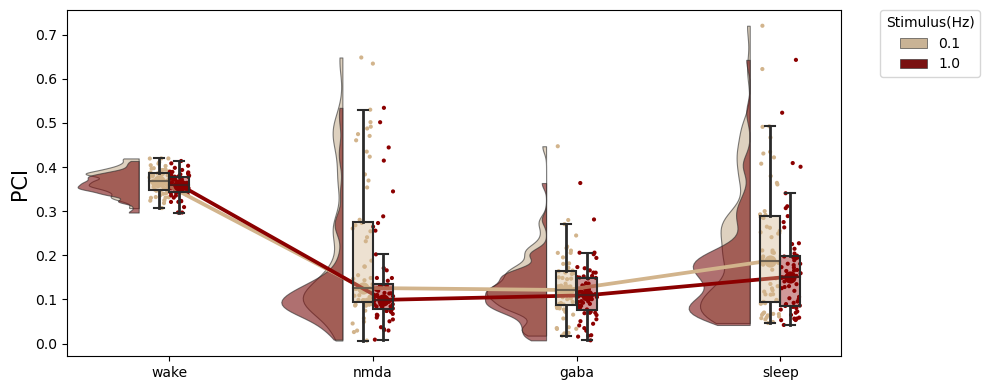

In [141]:
params = [[5, 3.75, 2], [60, 5, 2]] # b_e, tau, nseeds
conditions = ['nmda', 'sleep'] #conditions that the params describe
stimvals = [1e-3] #stimvals to load
n_trials=1 #how many trials were used for the PCI

pick_stim = [1, 0.1] # stimulus strength to plot

#set this to True if you want to plot the already run stims, it will load params automatically
local_folder= True 


plot_raincloud_with_stats(parameters, params, n_trials=n_trials, stimvals=stimvals, pick_stim=pick_stim, conditions= conditions, local_folder=local_folder)

### Simulating Bold Signal #

In [157]:
# Do that to initialize the parameters
parameters.__init__()

In [161]:
## Set the parameters of the simulation:
run_sim = 600.0 # ms, length of the simulation
cut_transient = 200.0 # ms, length of the discarded initial segment

# List of values of adaptation strength and tau_e which will vary the brain state
bvals = [5]
tau_es = [3.75]
Iexts = [0.000315] # External input

## Set the parameters of the stimulus (choose stimval = 0 to simulate spontaneous activity)
stimval = 0 #  stimulus strength

In [178]:
#Set Bold Monitor
parameters.parameter_monitor['Bold'] = True
parameters.parameter_monitor['parameter_Bold']['period'] = 2000 

#Deactivate Raw, and keep Temporal Average instead ( faster )
parameters.parameter_monitor['Raw'] = False
parameters.parameter_monitor['TemporalAverage'] = True
parameters.parameter_monitor['parameter_TemporalAverage']['variables_of_interest'] = [0,1]

In [ ]:
# Choose values of b_e and tau_e
bvals = [60, 5]
tau_es = [5, 3.75]

In [220]:
for b_e, tau_e in zip(bvals, tau_es):
    parameters = adjust_parameters(parameters, b_e = b_e, tau_e = tau_e , n_nodes=Nnodes,cut_transient=cut_transient, run_sim=run_sim,
                    stimval = stimval)
    simulator = sim_init(parameters)

_b_e_5_tau_e_3.75_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_10
2024-04-03 18:42:52,060 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
Different parameters of the two files:
Existing from json:  {'default': False, 'from_file': True, 'from_h5': False, 'path': 'C:\\Users\\maria\\Downloads\\tvb_data\\tvb_data\\connectivity', 'conn_name': 'connectivity_76.zip', 'number_of_regions': 0, 'tract_lengths': [], 'weights': [], 'speed': 4.0, 'normalised': True}
New one:  {'default': False, 'from_file': True, 'from_h5': False, 'path': '/home/maria/Downloads/tvb_data/connectivity', 'conn_name': 'connectivity_76.zip', 'number_of_regions': 0, 'tract_lengths': [], 'weights': [], 'speed': 4.0, 'normalised': True}


Continuing...
Adding new monitors 
Adding TempAvg
Adding Bold


In [163]:
if os.path.exists(parameters.parameter_simulation['path_result']+'/parameter.json'):
    print("ok")

ok


In [165]:
with open(parameters.parameter_simulation['path_result']+'/parameter.json', "r") as f:
    data = json.load(f)

In [167]:
type(data['parameter_model'])

dict

In [180]:
are_same = compare_dicts(data['parameter_monitor'], parameters.parameter_monitor)
print(are_same)

False


In [185]:
parameters.parameter_monitor

{'Raw': False,
 'TemporalAverage': True,
 'parameter_TemporalAverage': {'variables_of_interest': [0, 1],
  'period': 1.00},
 'Bold': True,
 'parameter_Bold': {'variables_of_interest': [0], 'period': 2000},
 'Ca': False,
 'parameter_Ca': {'variables_of_interest': [0, 1, 2],
  'tau_rise': 0.01,
  'tau_decay': 0.10}}

In [207]:
parameters.parameter_monitor

{'Raw': False,
 'TemporalAverage': True,
 'parameter_TemporalAverage': {'variables_of_interest': [0, 1],
  'period': 1.00},
 'Bold': True,
 'parameter_Bold': {'variables_of_interest': [0], 'period': 2000},
 'Ca': False,
 'parameter_Ca': {'variables_of_interest': [0, 1, 2],
  'tau_rise': 0.01,
  'tau_decay': 0.10}}

In [212]:
data

{'parameter_simulation': {'path_result': './result/synch/',
  'seed': 10,
  'save_time': 1000.00},
 'parameter_model': {'matteo': False,
  'order': 2,
  'g_L': 10.00,
  'E_L_e': -64.00,
  'E_L_i': -65.00,
  'C_m': 200.00,
  'b_e': 60.00,
  'a_e': 0.00,
  'b_i': 0.00,
  'a_i': 0.00,
  'tau_w_e': 500.00,
  'tau_w_i': 1.00,
  'E_e': 0.00,
  'E_i': -80.00,
  'Q_e': 1.50,
  'Q_i': 5.00,
  'tau_e': 5.00,
  'tau_i': 5.00,
  'N_tot': 10000,
  'p_connect_e': 0.05,
  'p_connect_i': 0.05,
  'g': 0.20,
  'T': 20.00,
  'P_e': [-0.05, 0.00, -0.01, -0.00, -0.00, 0.00, -0.01, 0.00, 0.00, -0.01],
  'P_i': [-0.05, 0.01, -0.01, 0.00, -0.00, 0.00, -0.03, 0.01, 0.00, -0.05],
  'external_input_ex_ex': 0.00,
  'external_input_ex_in': 0.00,
  'external_input_in_ex': 0.00,
  'external_input_in_in': 0.00,
  'tau_OU': 5.00,
  'weight_noise': 0.00,
  'K_ext_e': 400,
  'K_ext_i': 0,
  'initial_condition': {'E': [0.00, 0.00],
   'I': [0.00, 0.00],
   'C_ee': [0.00, 0.00],
   'C_ei': [0.00, 0.00],
   'C_ii': [0.00, 

In [206]:
data['parameter_monitor']

{'Raw': True,
 'TemporalAverage': False,
 'parameter_TemporalAverage': {'variables_of_interest': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7],
  'period': 1.00},
 'Bold': False,
 'parameter_Bold': {'variables_of_interest': [0], 'period': 200.00},
 'Ca': False,
 'parameter_Ca': {'variables_of_interest': [0, 1, 2],
  'tau_rise': 0.01,
  'tau_decay': 0.10}}

In [209]:
if data['parameter_model']['Raw']==True:
    print('ok')

KeyError: 'Raw'

In [211]:
if data['parameter_monitor']['Raw']==True and parameters.parameter_monitor['Raw']==False:
    print('ok')

ok


In [ ]:
for par_domain in data.keys():
    are_same = compare_dicts(data['parameter_monitor'], parameters.parameter_monitor)

In [203]:
list_param = [parameters.parameter_model ,
parameters.parameter_connection_between_region ,
parameters.parameter_coupling ,
parameters.parameter_integrator ] 

In [204]:
list_data = [data['parameter_model'],data['parameter_connection_between_region'],data['parameter_coupling'],data['parameter_integrator']]

In [205]:
for dic_param, dic_data in zip(list_param,list_data):
    if not compare_dicts(dic_param, dic_data):
        print(dic_data)
        print(dic_param)

In [ ]:
compare_dicts(data['parameter_model'] , parameters.parameter_model)
compare_dicts(data['parameter_connection_between_region'] , parameters.parameter_connection_between_region)
compare_dicts(data['parameter_simulation'] , parameters.parameter_simulation)
compare_dicts(data['parameter_coupling'] , parameters.parameter_coupling)
compare_dicts(data['parameter_integrator'] , parameters.parameter_integrator)
compare_dicts(data['myseed'] , parameters.myseed)

In [ ]:
compare_dicts(data['parameter_monitor'] , parameters.parameter_monitor)


In [196]:
for k in data.keys():
    print(f"data['{k}'],")

data['parameter_simulation'],
data['parameter_model'],
data['parameter_connection_between_region'],
data['parameter_coupling'],
data['parameter_integrator'],
data['parameter_monitor'],
data['myseed'],


In [177]:
parameters.parameter_monitor

{'Raw': True,
 'TemporalAverage': False,
 'parameter_TemporalAverage': {'variables_of_interest': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7],
  'period': 1.00},
 'Bold': False,
 'parameter_Bold': {'variables_of_interest': [0], 'period': 200.00},
 'Ca': False,
 'parameter_Ca': {'variables_of_interest': [0, 1, 2],
  'tau_rise': 0.01,
  'tau_decay': 0.10}}

In [176]:
are_same

True

In [168]:
def compare_dicts(dict1, dict2):
    """
    Compare two dictionaries for equality.
    """
    if len(dict1) != len(dict2):
        return False
    
    for key in dict1:
        if key not in dict2:
            return False
        if dict1[key] != dict2[key]:
            return False
    
    return True

In [172]:
data

{'parameter_simulation': {'path_result': './result/synch/',
  'seed': 10,
  'save_time': 1000.00},
 'parameter_model': {'matteo': False,
  'order': 2,
  'g_L': 10.00,
  'E_L_e': -64.00,
  'E_L_i': -65.00,
  'C_m': 200.00,
  'b_e': 60.00,
  'a_e': 0.00,
  'b_i': 0.00,
  'a_i': 0.00,
  'tau_w_e': 500.00,
  'tau_w_i': 1.00,
  'E_e': 0.00,
  'E_i': -80.00,
  'Q_e': 1.50,
  'Q_i': 5.00,
  'tau_e': 5.00,
  'tau_i': 5.00,
  'N_tot': 10000,
  'p_connect_e': 0.05,
  'p_connect_i': 0.05,
  'g': 0.20,
  'T': 20.00,
  'P_e': [-0.05, 0.00, -0.01, -0.00, -0.00, 0.00, -0.01, 0.00, 0.00, -0.01],
  'P_i': [-0.05, 0.01, -0.01, 0.00, -0.00, 0.00, -0.03, 0.01, 0.00, -0.05],
  'external_input_ex_ex': 0.00,
  'external_input_ex_in': 0.00,
  'external_input_in_ex': 0.00,
  'external_input_in_in': 0.00,
  'tau_OU': 5.00,
  'weight_noise': 0.00,
  'K_ext_e': 400,
  'K_ext_i': 0,
  'initial_condition': {'E': [0.00, 0.00],
   'I': [0.00, 0.00],
   'C_ee': [0.00, 0.00],
   'C_ei': [0.00, 0.00],
   'C_ii': [0.00, 

In [ ]:
# Run Simulation
for b_e, tau_e in zip(bvals, tau_es):
    parameters = adjust_parameters(parameters, b_e = b_e, tau_e = tau_e , 
                                   n_nodes=Nnodes,cut_transient=cut_transient, run_sim=run_sim)

    simulator = sim_init(parameters)
    
    if stimval:
        print ('    Stimulating for {1} ms, {2} nS in the {0}\n'.format(simulator.connectivity.region_labels[stim_region],parameters.parameter_stimulus['tau'],stimval))

    tools.run_simulation(simulator, run_sim, parameters.parameter_simulation, 
                         parameters.parameter_monitor)

In [122]:
df

,PCI,cond,stim,seed
0,0.002482,nmda,1.0,0
1,0.003701,nmda,1.0,1
2,0.018009,sleep,1.0,0
3,0.010115,sleep,1.0,1


In [127]:
df[df['cond'].isin(['nmda', 'sleep'])]

,PCI,cond,stim,seed
0,0.002482,nmda,1.0,0
1,0.003701,nmda,1.0,1
2,0.018009,sleep,1.0,0
3,0.010115,sleep,1.0,1


In [83]:
df_small

,PCI,cond,stim,seed
0,0.002482,nmda,1.0,0
1,0.003701,nmda,1.0,1
2,0.018009,sleep,1.0,0
3,0.010115,sleep,1.0,1
